# Предсказание цены домов

Источник данных
https://www.kaggle.com/harlfoxem/housesalesprediction

В этом ноутбуке будут опробаваны различные регрессоры, для того чтобы определить насколько они точны для определения цены домов.

<b>Содержание:</b>

<b>I. Анализ данных и визуализация</b>
1. Общая информация
2. Распределения данных и корреляции
3. Логнормальные распределения   

<b>II. Дома на карте</b>

<b>III. Предсказания цен домов</b>

1. Создание обучающего и тестового наборов
2. Анализ линейных коэффициентов
3. Множественная регрессия
4. Полиномиальная регрессия
        4.1. Полином 2-й степени
        4.1. Полином 3-й степени
5. k-NN регрессия
6. Random Forest
7. XGBoost
8. LightGBM
  

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

import arcgis
from arcgis.gis import GIS

import warnings
warnings.filterwarnings("ignore")


# Анализ данных и визуализация
## Общая информация

Загрузим файл и посмотрим что в нем есть.

In [2]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Удалим столбец 'id', он не понадобится.

In [3]:
del df['id']

#df['date'] = df['date'].apply(lambda x: x[4:6])
#df['date'] = df['date'].astype(int)

Для того, что бы можно было использовать в прогнозе дату продажи дома - необходимо преобразовать ее в день от начала года.

In [4]:
# 1) Оставим первые 8 символов
df['date'] = df['date'].apply(lambda x: x[:8])
# 2) Преобразуем str в тип datetime
df['date'] = df['date'].astype('datetime64[ns]')
# 3) Преобразуем дату в день от начала года
df['date'] = df['date'].apply(lambda x: x.timetuple().tm_yday)

In [5]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,286,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,343,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,56,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,343,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,49,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

**Названия столбцов:**

1. 'date' - Дата продажи	
2. 'price' - Цена	
3. 'bedrooms' - Спальни	
4. 'bathrooms' - Ванные комнаты	
5. 'sqft_living' -	Жилая площадь кв. фт.	
6. 'sqft_lot' - Площадь земли кв. фт.	
7. 'floors' - Этажность	
8. 'waterfront' - Побережье	
9. 'view' - Вид	
10. 'condition' - Сосотояние	
11. 'grade' - Класс	
12. 'sqft_above' - Площадь чердака кв. фт.	
13. 'sqft_basement' - Площадь подвала кв. фт.	
14. 'yr_built' - Год постройки	
15. 'yr_renovated' - Год восстановления	
16. 'zipcode' - Индекс	
17. 'lat' - Широта	
18. 'long' - Долгота	
19. 'sqft_living15' - Жилая площадь кв. фт. (15)	
20. 'sqft_lot15' - Площадь земли кв. фт. (15)	

In [7]:
# количество значений Null
df.isnull().sum().max()

0

In [8]:
# Общая статистика df
df.describe()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,184.314949,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,94.745659,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,2.000000,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,110.000000,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,178.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,262.000000,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,365.000000,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [9]:
'''
df1=df[['price', 'bedrooms', 'bathrooms', 'sqft_living',
    'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
    'lat', 'long', 'sqft_living15', 'sqft_lot15']]

df1 = df1.loc[:]

df1.loc[df1['yr_renovated'] == 0, 'yr_renovated'] = df1['yr_built']
df1.rename(columns={'yr_renovated': 'yr_built_or_renovated'}, inplace=True)
'''

"\ndf1=df[['price', 'bedrooms', 'bathrooms', 'sqft_living',\n    'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',\n    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',\n    'lat', 'long', 'sqft_living15', 'sqft_lot15']]\n\ndf1 = df1.loc[:]\n\ndf1.loc[df1['yr_renovated'] == 0, 'yr_renovated'] = df1['yr_built']\ndf1.rename(columns={'yr_renovated': 'yr_built_or_renovated'}, inplace=True)\n"

## Распределения данных и корреляции

**Гистограммы**

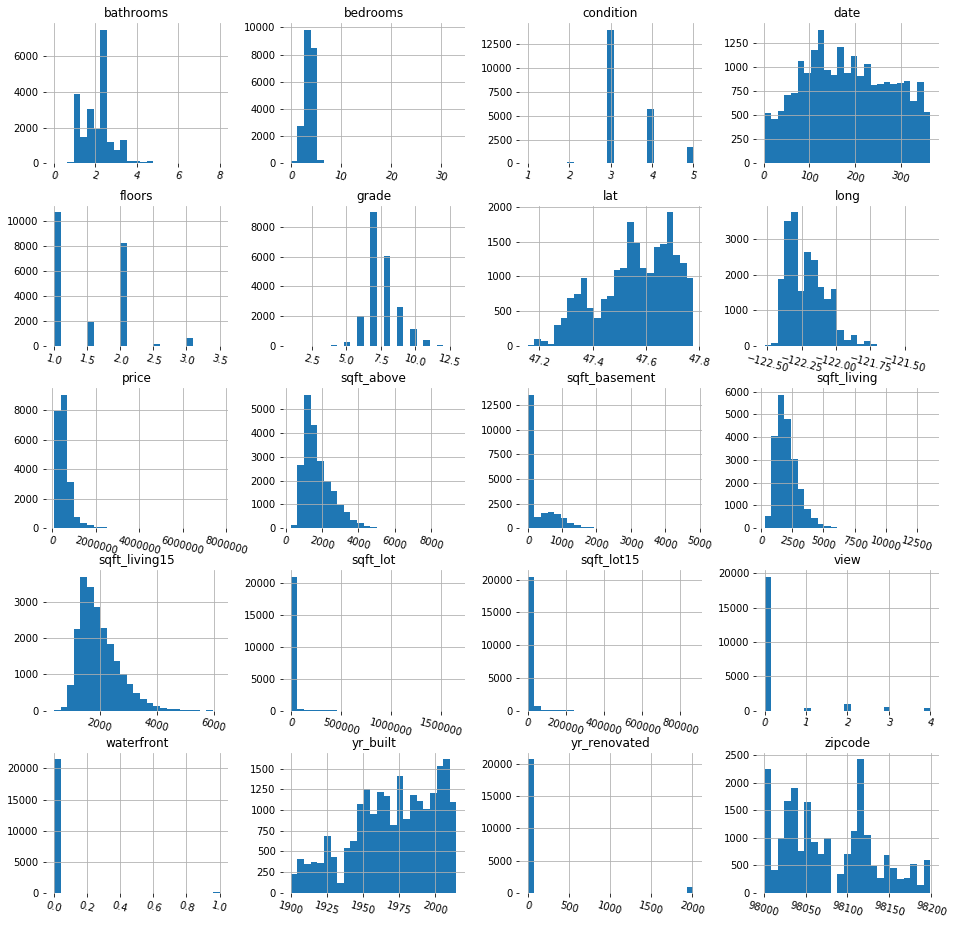

In [10]:
h = df.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

**Матрица корреляции**

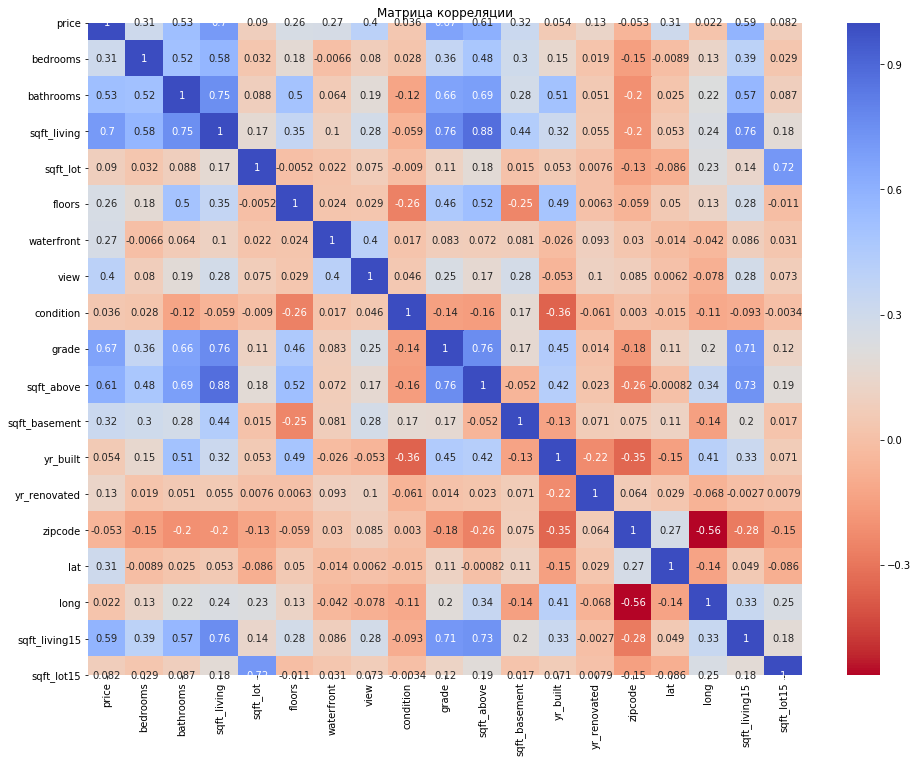

In [11]:
f = plt.figure(figsize=(16, 12))
corr = df.iloc[:,1:].corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=True, annot_kws={'size':10})
plt.title('Матрица корреляции', fontsize=12);

**Распределения данных по классам**

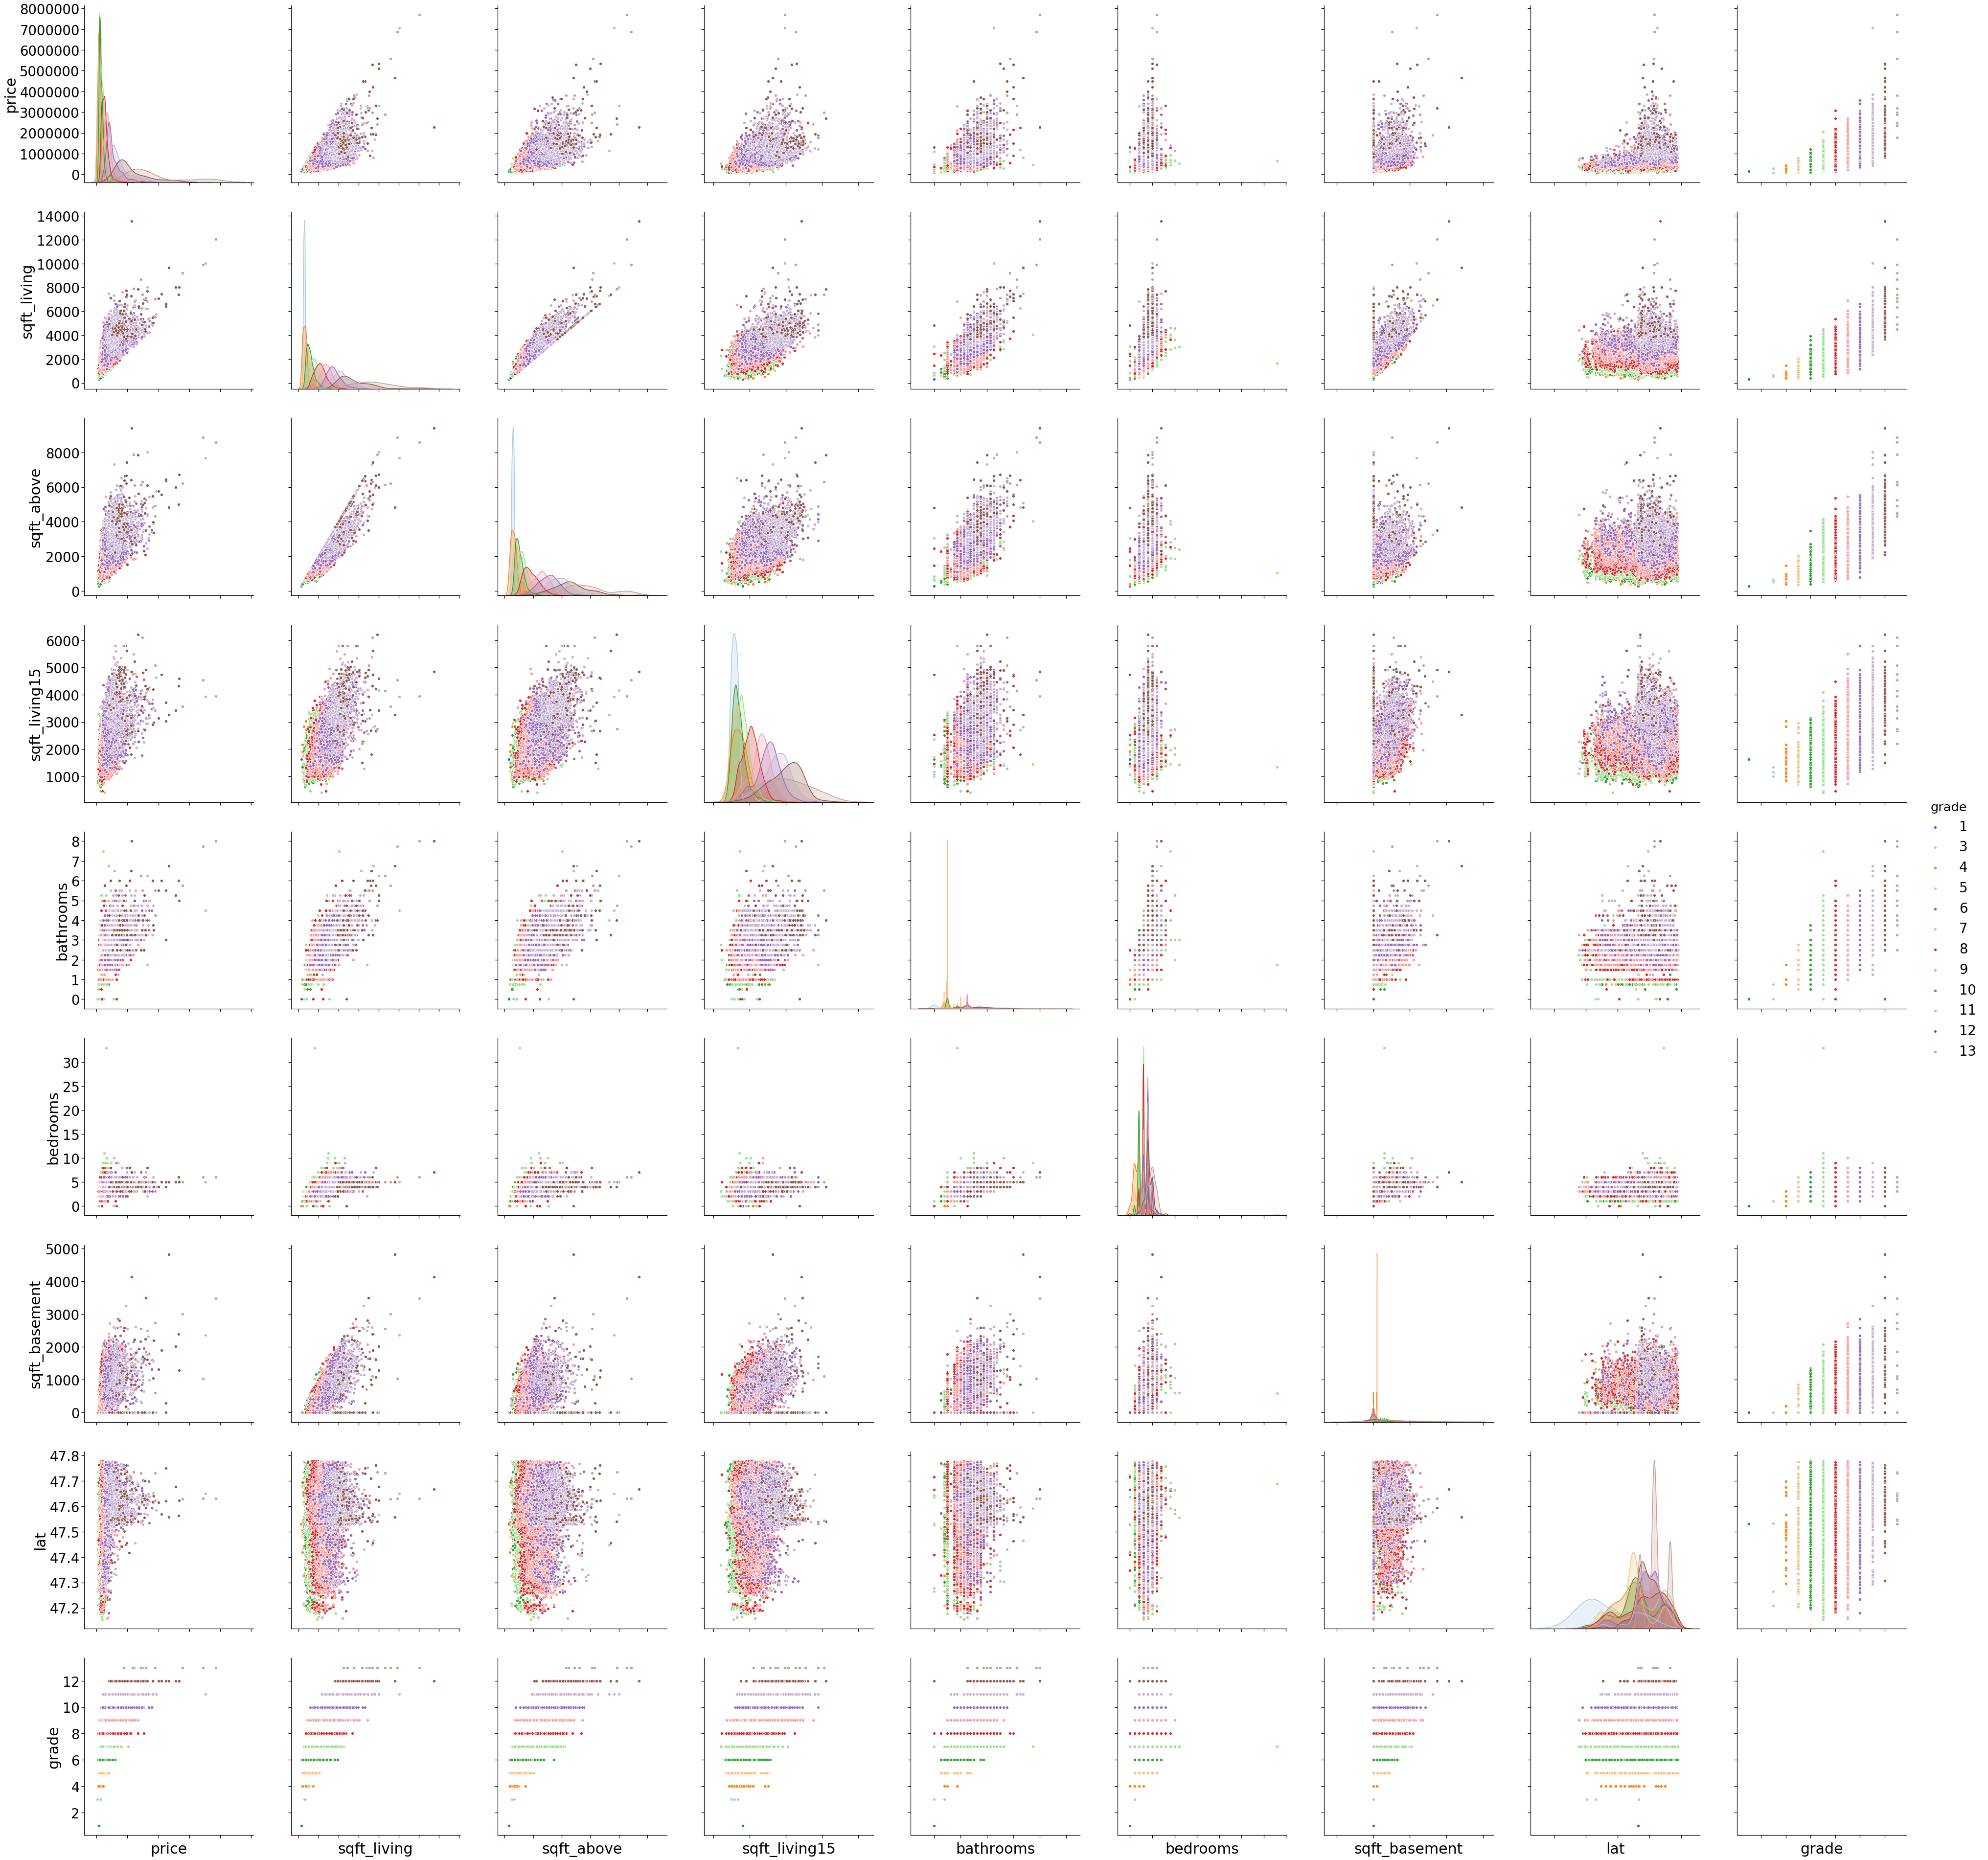

In [12]:
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(df[['price','sqft_living','sqft_above','sqft_living15',
                         'bathrooms','bedrooms','sqft_basement','lat', 'grade']], 
                 hue='grade', palette='tab20', size=6)
g.set(xticklabels=[]);

**Зависимость цены от жилой площади дома**

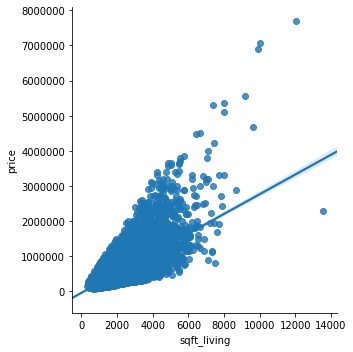

In [13]:
ax = sns.lmplot(x="sqft_living", y="price", data=df, hue=None)

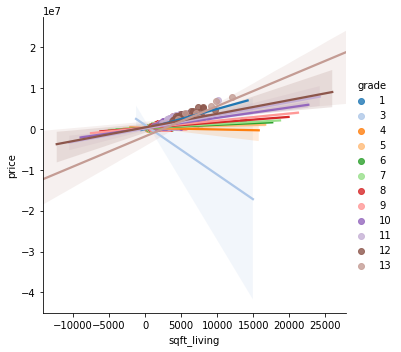

In [14]:
ax = sns.lmplot(x="sqft_living", y="price", data=df, hue="grade", palette='tab20')

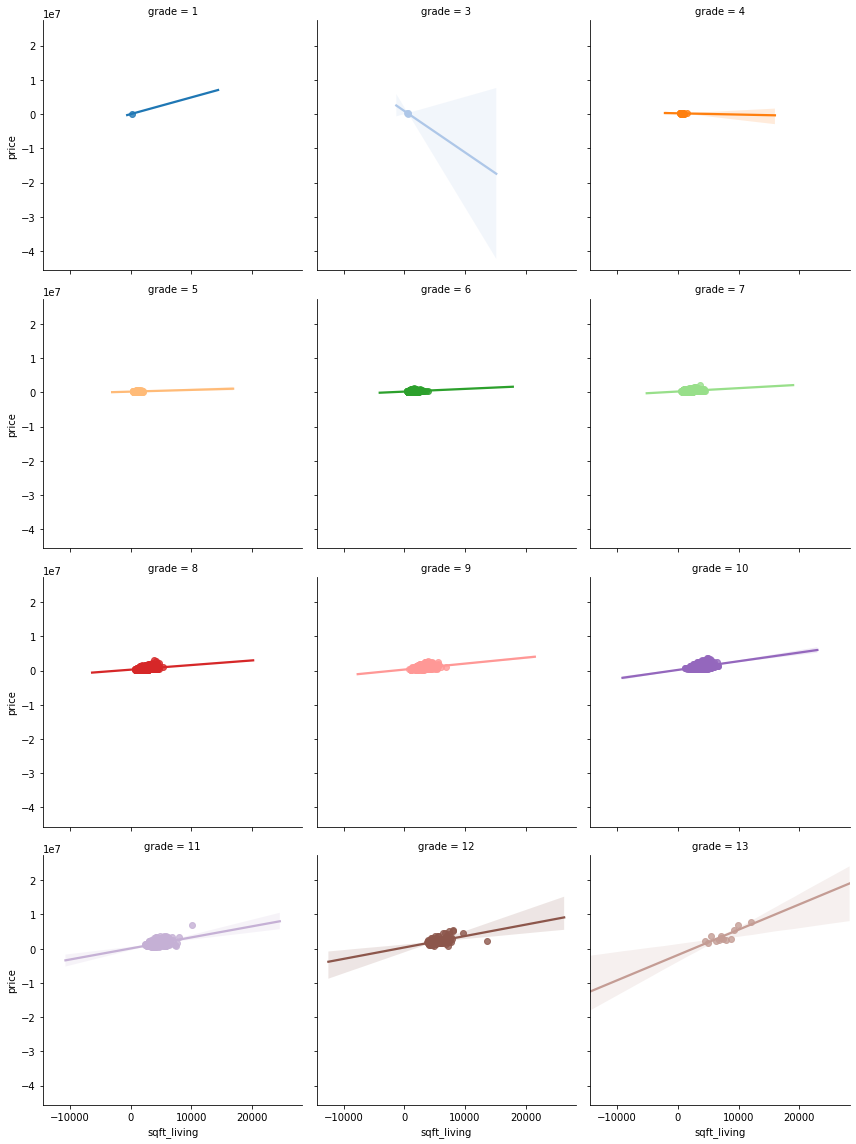

In [15]:
ax = sns.lmplot(x="sqft_living", y="price", data=df, palette='tab20', hue="grade", col="grade", col_wrap=3, height=4)

## Логнормальные распределения

In [16]:
df_lg = df.copy()
df_lg[['price','sqft_living','sqft_above','sqft_living15']] = np.log10(df[['price','sqft_living','sqft_above','sqft_living15']])
   
df_lg.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,286,5.346157,3,1.00,3.071882,5650,1.0,0,0,3,7,3.071882,0,1955,0,98178,47.5112,-122.257,3.127105,5650
1,343,5.730782,3,2.25,3.409933,7242,2.0,0,0,3,7,3.336460,400,1951,1991,98125,47.7210,-122.319,3.227887,7639
2,56,5.255273,2,1.00,2.886491,10000,1.0,0,0,3,6,2.886491,0,1933,0,98028,47.7379,-122.233,3.434569,8062
3,343,5.781037,4,3.00,3.292256,5000,1.0,0,0,5,7,3.021189,910,1965,0,98136,47.5208,-122.393,3.133539,5000
4,49,5.707570,3,2.00,3.225309,8080,1.0,0,0,3,8,3.225309,0,1987,0,98074,47.6168,-122.045,3.255273,7503


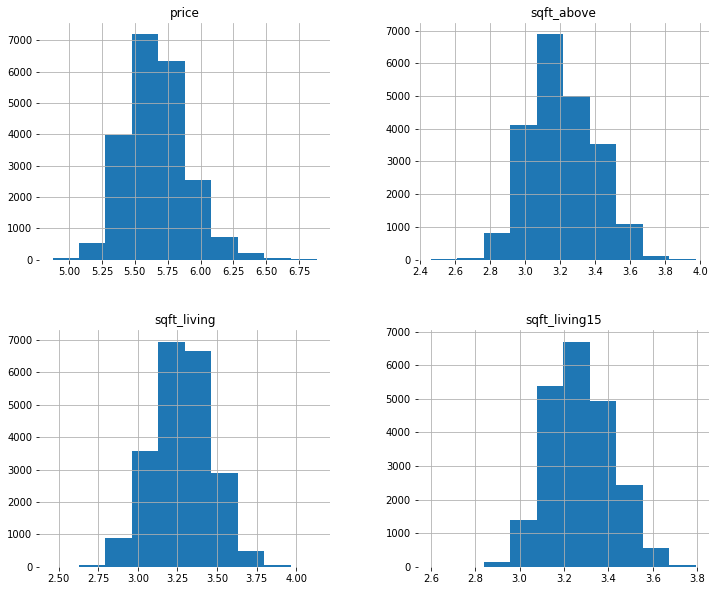

In [17]:
data = df_lg[['price','sqft_living','sqft_above','sqft_living15']]

h = data.hist(bins=10,figsize=(12,10),xlabelsize='10',ylabelsize='10')
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

## Дома на карте

In [18]:
df_m = df[['lat', 'long', 'grade']].copy()
df_m.head()

,lat,long,grade
0,47.5112,-122.257,7
1,47.7210,-122.319,7
2,47.7379,-122.233,6
3,47.5208,-122.393,7
4,47.6168,-122.045,8


In [19]:
my_gis = GIS(url='http://arcgis.com')

In [20]:
geo_df_m = my_gis.content.import_data(df_m[:999])

In [21]:
map_df_m = my_gis.map('Renton', zoomlevel=9.6)
map_df_m.basemap = 'osm'
map_df_m.add_layer(geo_df_m)
map_df_m

MapView(layout=Layout(height='400px', width='100%'), zoom=9.6)

In [22]:
#map_df_m = my_gis.map('Renton', zoomlevel=9.6)
#map_df_m.basemap = 'gray'
#map_df_m.add_layer(geo_df_m, {"renderer":"ClassedColorRenderer", "field_name":"grade"} )
#map_df_m.height = '600px'
#map_df_m

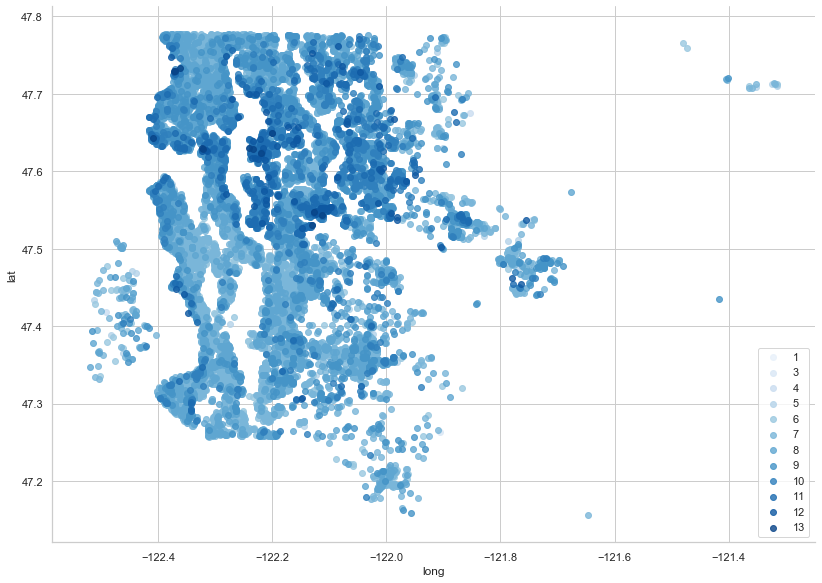

In [23]:
sns.set(style="whitegrid")
ax = sns.lmplot( x="long", y="lat", data=df, fit_reg=False, hue='grade', 
                legend=False, palette="Blues", height=8.27, aspect=1.4)
plt.legend(loc='lower right')
plt.show()

# Предсказания цен домов

## Создание обучающего и тестового наборов

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# разделяем данные на обучающий набор
# для данных в исходном виде
train, test = train_test_split(df,train_size = 0.8, random_state = 42)

# для данных в логарифмическом масштабе
train_lg, test_lg = train_test_split(df_lg,train_size = 0.8, random_state = 42)

In [26]:
x_train = train.drop(['price'], axis=1)
y_train = train.price

x_test = test.drop(['price'], axis=1)
y_test = test.price


x_train_lg = train_lg.drop(['price'], axis=1)
y_train_lg = train_lg.price

x_test_lg = test_lg.drop(['price'], axis=1)
y_test_lg = test_lg.price

In [27]:
print('Среднее значение цены y_train:', np.mean(y_train))
print('Среднее значение цены y_test:', np.mean(y_train))
print('Среднее значение цены y_train_lg:', 10 ** np.mean(y_train_lg))
print('Среднее значение цены y_test_lg:', 10 ** np.mean(y_train_lg))

Среднее значение цены y_train: 537768.04794679
Среднее значение цены y_test: 537768.04794679
Среднее значение цены y_train_lg: 462853.20449741324
Среднее значение цены y_test_lg: 462853.20449741324


## Анализ линейных коэффициентов

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [29]:
name = 'Linear Regression'
details = '-'

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Считаем качество модели.

In [30]:
print('Качество модели R2: train -', "%.3f" %  model.score(x_train, y_train), 
      'test -', "%.3f" %  model.score(x_test, y_test))

Качество модели R2: train - 0.700 test - 0.702


Выведем регрессионные коэффициенты от метода ```model.coef_``` и свободный член от метода ```model.intercept_```.

In [31]:
coef = pd.DataFrame(zip(['intercept'] + x_train.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,6.705467e+06
1,date,-1.039075e+02
2,bedrooms,-3.452464e+04
3,bathrooms,4.452651e+04
4,sqft_living,1.092101e+02
5,sqft_lot,8.959460e-02
6,floors,7.242229e+03
7,waterfront,5.631903e+05
8,view,5.339411e+04
9,condition,2.487847e+04


Определим статистическую значимость регрессионных коэффициентов.

In [32]:
from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef

In [33]:
regression_coef(model, x_test, y_test)

,predictor,coef,pvalue
0,intercept,6.705467e+06,3.268470e-01
1,date,-1.039075e+02,2.344802e-03
2,bedrooms,-3.452464e+04,2.087219e-14
3,bathrooms,4.452651e+04,3.578175e-09
4,sqft_living,1.092101e+02,9.999995e-01
5,sqft_lot,8.959460e-02,3.182691e-01
6,floors,7.242229e+03,3.987725e-01
7,waterfront,5.631903e+05,0.000000e+00
8,view,5.339411e+04,0.000000e+00
9,condition,2.487847e+04,8.659786e-06


У нас есть 3 статистически значимых свойства: ```sqft_living```, ```sqft_above``` и ```sqft_basement```.  Значение коэффициента говорит, на сколько вырастет значение сигнала при увеличении предиктора на одну единицу. 

- ```sqft_living``` - Жилая площадь кв. фт.
- ```sqft_above``` - Площадь чердака кв. фт. 	
- ```sqft_basement``` - Площадь подвала кв. фт. 	

Создадим наборы данных для статистически значимых признаков.

In [34]:
stat_sign = ['sqft_living','sqft_above','sqft_basement']

x_train_st = x_train[stat_sign]
x_test_st = x_test[stat_sign]

x_train_lg_st = x_train_lg[stat_sign]
x_test_lg_st = x_test_lg[stat_sign]

**Таблицы**

Созданим таблицы в которые будем записывать информацию по каждому регрессору.

In [35]:
table = pd.DataFrame(columns=['Regressor', 'Details', 'R^2 (train)', 'R^2 (test)', 
                              'mae (train)', 'mae (test)', 'rmse (train)', 'rmse (test)'])
table_lg = pd.DataFrame(columns=['Regressor', 'Details', 'R^2 (train)', 'R^2 (test)',
                                 'mae (train)', 'mae (test)', 'rmse (train)', 'rmse (test)'])

**Функции**

In [36]:
# создание списка со значениями метрик качества
def model_quality(model, x_train, y_train, x_test, y_test):
    k = list()
    k.append(model.score(x_train, y_train))
    k.append(model.score(x_test, y_test))
    k.append(mean_absolute_error(model.predict(x_train), y_train))
    k.append(mean_absolute_error(model.predict(x_test), y_test))
    k.append(np.sqrt(mean_squared_error(model.predict(x_train), y_train)))
    k.append(np.sqrt(mean_squared_error(model.predict(x_test), y_test)))
    return k

# для значений в логарифмическом мосштабе
def model_quality_lg(model, x_train, y_train, x_test, y_test):
    k = list()
    k.append(model.score(x_train, y_train))
    k.append(model.score(x_test, y_test))
    k.append(mean_absolute_error(10 ** model.predict(x_train), 10 ** y_train))
    k.append(mean_absolute_error(10 ** model.predict(x_test), 10 ** y_test))
    k.append(np.sqrt(mean_squared_error(10 ** model.predict(x_train), 10 ** y_train)))
    k.append(np.sqrt(mean_squared_error(10 ** model.predict(x_test), 10 ** y_test)))
    return k

# печать значений метрик
def print_quality(k):
    print ('R2 - train:', "%.3f" % k[0], 'test:', "%.3f" % k[1])
    print ('mae - train:', "%.3f" % k[2], 'test:', "%.3f" % k[3])
    print ('rmse - train:', "%.3f" % k[4], 'test:', "%.3f" % k[5])

# add regressor information to the table
def add_to_table(table, name, details, k):
    table.loc[len(table)] = [name, details, k[0], k[1], k[2], k[3], k[4], k[5]]

## Множественная регрессия

In [37]:
# Исходный набор
name_lr = 'Multiple'
details_lr = '-'
lr = LinearRegression()
lr.fit(x_train, y_train)
k_lr = model_quality(lr, x_train, y_train, x_test, y_test)
add_to_table(table, name_lr, details_lr, k_lr)
print('MODEL: ', name_lr, details_lr)
print_quality(k_lr)
##############################################################################################

# Статистически значимые величины
name_lr_st = 'Multiple'
details_lr_st = 'stat. sign. f.'
lr_st = LinearRegression()
lr_st.fit(x_train_st, y_train)
k_lr_st = model_quality(lr_st, x_train_st, y_train, x_test_st, y_test)
add_to_table(table, name_lr_st, details_lr_st, k_lr_st)
print('\nMODEL: ', name_lr_st, details_lr_st)
print_quality(k_lr_st)
##############################################################################################


# Регрессия для наборов с логорифмированными величинами

# Исходный набор с логарифмированными величинами
name_lr_lg = 'Multiple'
details_lr_lg = '-'
lr_lg = LinearRegression()
lr_lg.fit(x_train_lg, y_train_lg)
k_lr_lg = model_quality_lg(lr_lg, x_train_lg, y_train_lg, x_test_lg, y_test_lg)
add_to_table(table_lg, name_lr_lg, details_lr_lg, k_lr_lg)
print('\nMODEL: ', name_lr_lg, details_lr_lg)
print_quality(k_lr_lg)
##############################################################################################

# Логарифмированные статистически значимые величины
name_lr_lg_st = 'Multiple'
details_lr_lg_st = 'stat. sign. f.'
lr_lg_st = LinearRegression()
lr_lg_st.fit(x_train_lg_st, y_train_lg)
k_lr_lg_st = model_quality_lg(lr_lg_st, x_train_lg_st, y_train_lg, x_test_lg_st, y_test_lg)
add_to_table(table_lg, name_lr_lg_st, details_lr_lg_st, k_lr_lg_st)
print('\nMODEL: ', name_lr_lg_st, details_lr_lg_st)
print_quality(k_lr_lg_st)
##############################################################################################

MODEL:  Multiple -
R2 - train: 0.700 test: 0.702
mae - train: 124857.130 test: 127056.448
rmse - train: 198028.579 test: 212304.120

MODEL:  Multiple stat. sign. f.
R2 - train: 0.493 test: 0.494
mae - train: 172293.648 test: 177965.956
rmse - train: 257391.061 test: 276558.409

MODEL:  Multiple -
R2 - train: 0.772 test: 0.777
mae - train: 108009.985 test: 112848.800
rmse - train: 178346.713 test: 205349.223

MODEL:  Multiple stat. sign. f.
R2 - train: 0.462 test: 0.478
mae - train: 166392.873 test: 172297.706
rmse - train: 263046.883 test: 291612.387


In [38]:
table

,Regressor,Details,R^2 (train),R^2 (test),mae (train),mae (test),rmse (train),rmse (test)
0,Multiple,-,0.699841,0.701852,124857.130281,127056.448012,198028.578851,212304.119847
1,Multiple,stat. sign. f.,0.492913,0.494072,172293.648243,177965.955509,257391.060605,276558.409155


In [39]:
table_lg

,Regressor,Details,R^2 (train),R^2 (test),mae (train),mae (test),rmse (train),rmse (test)
0,Multiple,-,0.772317,0.777052,108009.985282,112848.799538,178346.712776,205349.222938
1,Multiple,stat. sign. f.,0.461556,0.478444,166392.872502,172297.705704,263046.883045,291612.386868


## Полиномиальная регрессия

In [40]:
from sklearn.preprocessing import PolynomialFeatures

### Полином 2 степени

In [41]:
# Исходный набор
name_poly2 = 'Polynomial 2'
details_poly2 = '-'
#############
polyfeat_p2 = PolynomialFeatures(degree=2)
x_train_p2 = polyfeat_p2.fit_transform(x_train)
x_test_p2 = polyfeat_p2.fit_transform(x_test)
#############
poly2 = LinearRegression()
poly2.fit(x_train_p2, y_train)
k_poly2 = model_quality(poly2, x_train_p2, y_train, x_test_p2, y_test)
add_to_table(table, name_poly2, details_poly2, k_poly2)
print('MODEL: ', name_poly2, details_poly2)
print_quality(k_poly2)
##############################################################################################

# Статистически значимые величины
name_poly2_st = 'Polynomial 2'
details_poly2_st = 'stat. sign. f.'
#############
polyfeat_p2_st = PolynomialFeatures(degree=2)
x_train_p2_st = polyfeat_p2.fit_transform(x_train_st)
x_test_p2_st = polyfeat_p2.fit_transform(x_test_st)
#############
poly2_st = LinearRegression()
poly2_st.fit(x_train_p2_st, y_train)
k_poly2_st = model_quality(poly2_st, x_train_p2_st, y_train, x_test_p2_st, y_test)
add_to_table(table, name_poly2_st, details_poly2_st, k_poly2_st)
print('\nMODEL: ', name_poly2_st, details_poly2_st)
print_quality(k_poly2_st)
##############################################################################################


# Регрессия для наборов с логорифмированными величинами

# Исходный набор с логарифмированными величинами
name_poly2_lg = 'Polynomial 2'
details_poly2_lg = '-'
#############
polyfeat_p2_lg = PolynomialFeatures(degree=2)
x_train_p2_lg = polyfeat_p2.fit_transform(x_train_lg)
x_test_p2_lg = polyfeat_p2.fit_transform(x_test_lg)
#############
poly2_lg = LinearRegression()
poly2_lg.fit(x_train_p2_lg, y_train_lg)
k_poly2_lg = model_quality_lg(poly2_lg, x_train_p2_lg, y_train_lg, x_test_p2_lg, y_test_lg)
add_to_table(table_lg, name_poly2_lg, details_poly2_lg, k_poly2_lg)
print('\nMODEL: ', name_poly2_lg, details_poly2_lg)
print_quality(k_poly2_lg)
##############################################################################################

# Логарифмированные статистически значимые величины
name_poly2_lg_st = 'Polynomial 2'
details_poly2_lg_st = 'stat. sign. f.'
#############
polyfeat_p2_lg_st = PolynomialFeatures(degree=2)
x_train_p2_lg_st = polyfeat_p2_lg_st.fit_transform(x_train_lg_st)
x_test_p2_lg_st = polyfeat_p2_lg_st.fit_transform(x_test_lg_st)
#############
poly2_lg_st = LinearRegression()
poly2_lg_st.fit(x_train_p2_lg_st, y_train_lg)
k_poly2_lg_st = model_quality_lg(poly2_lg_st, x_train_p2_lg_st, y_train_lg, x_test_p2_lg_st, y_test_lg)
add_to_table(table_lg, name_poly2_lg_st, details_poly2_lg_st, k_poly2_lg_st)
print('\nMODEL: ', name_poly2_lg_st, details_poly2_lg_st)
print_quality(k_poly2_lg_st)
##############################################################################################

MODEL:  Polynomial 2 -
R2 - train: 0.835 test: 0.799
mae - train: 96676.246 test: 103998.180
rmse - train: 146706.058 test: 174448.567

MODEL:  Polynomial 2 stat. sign. f.
R2 - train: 0.557 test: 0.446
mae - train: 161615.330 test: 171078.974
rmse - train: 240472.714 test: 289274.669

MODEL:  Polynomial 2 -
R2 - train: 0.832 test: 0.827
mae - train: 87930.060 test: 95622.592
rmse - train: 143171.880 test: 176593.881

MODEL:  Polynomial 2 stat. sign. f.
R2 - train: 0.492 test: 0.502
mae - train: 159992.862 test: 167374.685
rmse - train: 248460.358 test: 269058.107


In [42]:
table

,Regressor,Details,R^2 (train),R^2 (test),mae (train),mae (test),rmse (train),rmse (test)
0,Multiple,-,0.699841,0.701852,124857.130281,127056.448012,198028.578851,212304.119847
1,Multiple,stat. sign. f.,0.492913,0.494072,172293.648243,177965.955509,257391.060605,276558.409155
2,Polynomial 2,-,0.835263,0.798697,96676.246063,103998.179539,146706.057989,174448.567250
3,Polynomial 2,stat. sign. f.,0.557384,0.446477,161615.329523,171078.973741,240472.713771,289274.669182


In [43]:
table_lg

,Regressor,Details,R^2 (train),R^2 (test),mae (train),mae (test),rmse (train),rmse (test)
0,Multiple,-,0.772317,0.777052,108009.985282,112848.799538,178346.712776,205349.222938
1,Multiple,stat. sign. f.,0.461556,0.478444,166392.872502,172297.705704,263046.883045,291612.386868
2,Polynomial 2,-,0.832368,0.826607,87930.059804,95622.592211,143171.879811,176593.881469
3,Polynomial 2,stat. sign. f.,0.492223,0.501699,159992.861970,167374.685389,248460.357597,269058.106655


### Полином 3 степени

In [44]:
# Исходный набор
name_poly3 = 'Polynomial 3'
details_poly3 = '-'
#############
polyfeat_p3 = PolynomialFeatures(degree=3)
x_train_p3 = polyfeat_p3.fit_transform(x_train)
x_test_p3 = polyfeat_p3.fit_transform(x_test)
#############
poly3 = LinearRegression()
poly3.fit(x_train_p3, y_train)
k_poly3 = model_quality(poly3, x_train_p3, y_train, x_test_p3, y_test)
add_to_table(table, name_poly3, details_poly3, k_poly3)
print('MODEL: ', name_poly3, details_poly3)
print_quality(k_poly3)
##############################################################################################

# Статистически значимые величины
name_poly3_st = 'Polynomial 3'
details_poly3_st = 'stat. sign. f.'
#############
polyfeat_p3_st = PolynomialFeatures(degree=3)
x_train_p3_st = polyfeat_p3.fit_transform(x_train_st)
x_test_p3_st = polyfeat_p3.fit_transform(x_test_st)
#############
poly3_st = LinearRegression()
poly3_st.fit(x_train_p3_st, y_train)
k_poly3_st = model_quality(poly3_st, x_train_p3_st, y_train, x_test_p3_st, y_test)
add_to_table(table, name_poly3_st, details_poly3_st, k_poly3_st)
print('\nMODEL: ', name_poly3_st, details_poly3_st)
print_quality(k_poly3_st)
##############################################################################################


# Регрессия для наборов с логорифмированными величинами

# Исходный набор с логарифмированными величинами
name_poly3_lg = 'Polynomial 3'
details_poly3_lg = '-'
#############
polyfeat_p3_lg = PolynomialFeatures(degree=3)
x_train_p3_lg = polyfeat_p3.fit_transform(x_train_lg)
x_test_p3_lg = polyfeat_p3.fit_transform(x_test_lg)
#############
poly3_lg = LinearRegression()
poly3_lg.fit(x_train_p3_lg, y_train_lg)
k_poly3_lg = model_quality_lg(poly3_lg, x_train_p3_lg, y_train_lg, x_test_p3_lg, y_test_lg)
add_to_table(table_lg, name_poly3_lg, details_poly3_lg, k_poly3_lg)
print('\nMODEL: ', name_poly3_lg, details_poly3_lg)
print_quality(k_poly3_lg)
##############################################################################################

# Логарифмированные статистически значимые величины
name_poly3_lg_st = 'Polynomial 3'
details_poly3_lg_st = 'stat. sign. f.'
#############
polyfeat_p3_lg_st = PolynomialFeatures(degree=3)
x_train_p3_lg_st = polyfeat_p3_lg_st.fit_transform(x_train_lg_st)
x_test_p3_lg_st = polyfeat_p3_lg_st.fit_transform(x_test_lg_st)
#############
poly3_lg_st = LinearRegression()
poly3_lg_st.fit(x_train_p3_lg_st, y_train_lg)
k_poly3_lg_st = model_quality_lg(poly3_lg_st, x_train_p3_lg_st, y_train_lg, x_test_p3_lg_st, y_test_lg)
add_to_table(table_lg, name_poly3_lg_st, details_poly3_lg_st, k_poly3_lg_st)
print('\nMODEL: ', name_poly3_lg_st, details_poly3_lg_st)
print_quality(k_poly3_lg_st)
##############################################################################################

MODEL:  Polynomial 3 -
R2 - train: 0.837 test: -0.212
mae - train: 100205.427 test: 130006.876
rmse - train: 145741.880 test: 427969.849

MODEL:  Polynomial 3 stat. sign. f.
R2 - train: 0.559 test: 0.464
mae - train: 161236.702 test: 170762.792
rmse - train: 240058.709 test: 284709.570

MODEL:  Polynomial 3 -
R2 - train: 0.849 test: -0.386
mae - train: 81889.136 test: 161685.457
rmse - train: 129385.758 test: 2409604.585

MODEL:  Polynomial 3 stat. sign. f.
R2 - train: 0.499 test: 0.501
mae - train: 159465.370 test: 177009.887
rmse - train: 250234.940 test: 756320.014


In [45]:
table

,Regressor,Details,R^2 (train),R^2 (test),mae (train),mae (test),rmse (train),rmse (test)
0,Multiple,-,0.699841,0.701852,124857.130281,127056.448012,198028.578851,212304.119847
1,Multiple,stat. sign. f.,0.492913,0.494072,172293.648243,177965.955509,257391.060605,276558.409155
2,Polynomial 2,-,0.835263,0.798697,96676.246063,103998.179539,146706.057989,174448.567250
3,Polynomial 2,stat. sign. f.,0.557384,0.446477,161615.329523,171078.973741,240472.713771,289274.669182
4,Polynomial 3,-,0.837421,-0.211550,100205.427497,130006.875809,145741.879990,427969.848977
5,Polynomial 3,stat. sign. f.,0.558907,0.463809,161236.701772,170762.791675,240058.708727,284709.570489


In [46]:
table_lg

,Regressor,Details,R^2 (train),R^2 (test),mae (train),mae (test),rmse (train),rmse (test)
0,Multiple,-,0.772317,0.777052,108009.985282,112848.799538,178346.712776,2.053492e+05
1,Multiple,stat. sign. f.,0.461556,0.478444,166392.872502,172297.705704,263046.883045,2.916124e+05
2,Polynomial 2,-,0.832368,0.826607,87930.059804,95622.592211,143171.879811,1.765939e+05
3,Polynomial 2,stat. sign. f.,0.492223,0.501699,159992.861970,167374.685389,248460.357597,2.690581e+05
4,Polynomial 3,-,0.848868,-0.385758,81889.135610,161685.457439,129385.758245,2.409605e+06
5,Polynomial 3,stat. sign. f.,0.499308,0.501195,159465.369500,177009.886510,250234.939626,7.563200e+05


## k-NN

In [47]:
from sklearn.neighbors import KNeighborsRegressor

In [48]:
# Исходный набор
name_knnr = 'k-NN'
details_knnr = 'k=12'
knnr = KNeighborsRegressor(n_neighbors=12)
knnr.fit(x_train, y_train)
k_knnr = model_quality(knnr, x_train, y_train, x_test, y_test)
add_to_table(table, name_knnr, details_knnr, k_knnr)
print('MODEL: ', name_knnr, details_knnr)
print_quality(k_knnr)
##############################################################################################

# Статистически значимые величины
name_knnr_st = 'k-NN'
details_knnr_st = 'stat. sign. f., k=12'
knnr_st = KNeighborsRegressor(n_neighbors=12)
knnr_st.fit(x_train_st, y_train)
k_knnr_st = model_quality(knnr_st, x_train_st, y_train, x_test_st, y_test)
add_to_table(table, name_knnr_st, details_knnr_st, k_knnr_st)
print('\nMODEL: ', name_knnr_st, details_knnr_st)
print_quality(k_knnr_st)
##############################################################################################


# Регрессия для наборов с логорифмированными величинами

# Исходный набор с логарифмированными величинами
name_knnr_lg = 'k-NN'
details_knnr_lg = 'k=12'
knnr_lg = KNeighborsRegressor(n_neighbors=12)
knnr_lg.fit(x_train_lg, y_train_lg)
k_knnr_lg = model_quality_lg(knnr_lg, x_train_lg, y_train_lg, x_test_lg, y_test_lg)
add_to_table(table_lg, name_knnr_lg, details_knnr_lg, k_knnr_lg)
print('\nMODEL: ', name_knnr_lg, details_knnr_lg)
print_quality(k_knnr_lg)
##############################################################################################

# Логарифмированные статистически значимые величины
name_knnr_lg_st = 'k-NN'
details_knnr_lg_st = 'stat. sign. f., k=12'
knnr_lg_st = KNeighborsRegressor(n_neighbors=12)
knnr_lg_st.fit(x_train_lg_st, y_train_lg)
k_knnr_lg_st = model_quality_lg(knnr_lg_st, x_train_lg_st, y_train_lg, x_test_lg_st, y_test_lg)
add_to_table(table_lg, name_knnr_lg_st, details_knnr_lg_st, k_knnr_lg_st)
print('\nMODEL: ', name_knnr_lg_st, details_knnr_lg_st)
print_quality(k_knnr_lg_st)
##############################################################################################

MODEL:  k-NN k=12
R2 - train: 0.587 test: 0.523
mae - train: 139651.221 test: 158091.766
rmse - train: 232406.305 test: 268495.502

MODEL:  k-NN stat. sign. f., k=12
R2 - train: 0.580 test: 0.518
mae - train: 156853.223 test: 173340.788
rmse - train: 234273.018 test: 269971.151

MODEL:  k-NN k=12
R2 - train: 0.274 test: 0.159
mae - train: 189338.425 test: 210212.564
rmse - train: 326193.113 test: 366915.646

MODEL:  k-NN stat. sign. f., k=12
R2 - train: 0.500 test: 0.448
mae - train: 158590.628 test: 175115.132
rmse - train: 264137.891 test: 306516.242


In [49]:
table

,Regressor,Details,R^2 (train),R^2 (test),mae (train),mae (test),rmse (train),rmse (test)
0,Multiple,-,0.699841,0.701852,124857.130281,127056.448012,198028.578851,212304.119847
1,Multiple,stat. sign. f.,0.492913,0.494072,172293.648243,177965.955509,257391.060605,276558.409155
2,Polynomial 2,-,0.835263,0.798697,96676.246063,103998.179539,146706.057989,174448.567250
3,Polynomial 2,stat. sign. f.,0.557384,0.446477,161615.329523,171078.973741,240472.713771,289274.669182
4,Polynomial 3,-,0.837421,-0.211550,100205.427497,130006.875809,145741.879990,427969.848977
5,Polynomial 3,stat. sign. f.,0.558907,0.463809,161236.701772,170762.791675,240058.708727,284709.570489
6,k-NN,k=12,0.586580,0.523142,139651.221125,158091.765865,232406.305058,268495.501776
7,k-NN,"stat. sign. f., k=12",0.579913,0.517886,156853.223477,173340.788457,234273.018154,269971.151044


In [50]:
table_lg

,Regressor,Details,R^2 (train),R^2 (test),mae (train),mae (test),rmse (train),rmse (test)
0,Multiple,-,0.772317,0.777052,108009.985282,112848.799538,178346.712776,2.053492e+05
1,Multiple,stat. sign. f.,0.461556,0.478444,166392.872502,172297.705704,263046.883045,2.916124e+05
2,Polynomial 2,-,0.832368,0.826607,87930.059804,95622.592211,143171.879811,1.765939e+05
3,Polynomial 2,stat. sign. f.,0.492223,0.501699,159992.861970,167374.685389,248460.357597,2.690581e+05
4,Polynomial 3,-,0.848868,-0.385758,81889.135610,161685.457439,129385.758245,2.409605e+06
5,Polynomial 3,stat. sign. f.,0.499308,0.501195,159465.369500,177009.886510,250234.939626,7.563200e+05
6,k-NN,k=12,0.273888,0.158810,189338.425304,210212.564051,326193.113237,3.669156e+05
7,k-NN,"stat. sign. f., k=12",0.499744,0.447785,158590.627884,175115.132345,264137.890883,3.065162e+05


## Random Forest

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
# Исходный набор
name_rf = 'Random Forest'
details_rf = 'n_jobs=-1, n_estimators=55'
rf = RandomForestRegressor(n_jobs=-1, n_estimators=55)
rf.fit(x_train, y_train)
k_rf = model_quality(rf, x_train, y_train, x_test, y_test)
add_to_table(table, name_rf, details_rf, k_rf)
print('MODEL: ', name_rf, details_rf)
print_quality(k_rf)
##############################################################################################

# Статистически значимые величины
name_rf_st = 'Random Forest'
details_rf_st = 'stat. sign. f., n_jobs=-1, n_estimators=55'
rf_st = RandomForestRegressor(n_jobs=-1, n_estimators=55)
rf_st.fit(x_train_st, y_train)
k_rf_st = model_quality(rf_st, x_train_st, y_train, x_test_st, y_test)
add_to_table(table, name_rf_st, details_rf_st, k_rf_st)
print('\nMODEL: ', name_rf_st, details_rf_st)
print_quality(k_rf_st)
##############################################################################################


# Регрессия для наборов с логорифмированными величинами

# Исходный набор с логарифмированными величинами
name_rf_lg = 'Random Forest'
details_rf_lg = 'n_jobs=-1, n_estimators=55'
rf_lg = RandomForestRegressor(n_jobs=-1, n_estimators=55)
rf_lg.fit(x_train_lg, y_train_lg)
k_rf_lg = model_quality_lg(rf_lg, x_train_lg, y_train_lg, x_test_lg, y_test_lg)
add_to_table(table_lg, name_rf_lg, details_rf_lg, k_rf_lg)
print('\nMODEL: ', name_rf_lg, details_rf_lg)
print_quality(k_rf_lg)
##############################################################################################

# Логарифмированные статистически значимые величины
name_rf_lg_st = 'Random Forest'
details_rf_lg_st = 'stat. sign. f., n_jobs=-1, n_estimators=55'
rf_lg_st = RandomForestRegressor(n_jobs=-1, n_estimators=55)
rf_lg_st.fit(x_train_lg_st, y_train_lg)
k_rf_lg_st = model_quality_lg(rf_lg_st, x_train_lg_st, y_train_lg, x_test_lg_st, y_test_lg)
add_to_table(table_lg, name_rf_lg_st, details_rf_lg_st, k_rf_lg_st)
print('\nMODEL: ', name_rf_lg_st, details_rf_lg_st)
print_quality(k_rf_lg_st)
##############################################################################################

MODEL:  Random Forest n_jobs=-1, n_estimators=55
R2 - train: 0.981 test: 0.858
mae - train: 26088.755 test: 72893.403
rmse - train: 49906.138 test: 146572.307

MODEL:  Random Forest stat. sign. f., n_jobs=-1, n_estimators=55
R2 - train: 0.777 test: 0.443
mae - train: 117435.663 test: 176853.827
rmse - train: 170558.227 test: 290119.156

MODEL:  Random Forest n_jobs=-1, n_estimators=55
R2 - train: 0.983 test: 0.891
mae - train: 26533.773 test: 72759.031
rmse - train: 53837.064 test: 138669.892

MODEL:  Random Forest stat. sign. f., n_jobs=-1, n_estimators=55
R2 - train: 0.661 test: 0.452
mae - train: 116693.310 test: 174935.324
rmse - train: 176231.002 test: 291143.805


In [53]:
table

,Regressor,Details,R^2 (train),R^2 (test),mae (train),mae (test),rmse (train),rmse (test)
0,Multiple,-,0.699841,0.701852,124857.130281,127056.448012,198028.578851,212304.119847
1,Multiple,stat. sign. f.,0.492913,0.494072,172293.648243,177965.955509,257391.060605,276558.409155
2,Polynomial 2,-,0.835263,0.798697,96676.246063,103998.179539,146706.057989,174448.567250
3,Polynomial 2,stat. sign. f.,0.557384,0.446477,161615.329523,171078.973741,240472.713771,289274.669182
4,Polynomial 3,-,0.837421,-0.211550,100205.427497,130006.875809,145741.879990,427969.848977
5,Polynomial 3,stat. sign. f.,0.558907,0.463809,161236.701772,170762.791675,240058.708727,284709.570489
6,k-NN,k=12,0.586580,0.523142,139651.221125,158091.765865,232406.305058,268495.501776
7,k-NN,"stat. sign. f., k=12",0.579913,0.517886,156853.223477,173340.788457,234273.018154,269971.151044
8,Random Forest,"n_jobs=-1, n_estimators=55",0.980936,0.857892,26088.755027,72893.402881,49906.137646,146572.306675
9,Random Forest,"stat. sign. f., n_jobs=-1, n_estimators=55",0.777341,0.443240,117435.663342,176853.827467,170558.227302,290119.155609


In [54]:
table_lg

,Regressor,Details,R^2 (train),R^2 (test),mae (train),mae (test),rmse (train),rmse (test)
0,Multiple,-,0.772317,0.777052,108009.985282,112848.799538,178346.712776,2.053492e+05
1,Multiple,stat. sign. f.,0.461556,0.478444,166392.872502,172297.705704,263046.883045,2.916124e+05
2,Polynomial 2,-,0.832368,0.826607,87930.059804,95622.592211,143171.879811,1.765939e+05
3,Polynomial 2,stat. sign. f.,0.492223,0.501699,159992.861970,167374.685389,248460.357597,2.690581e+05
4,Polynomial 3,-,0.848868,-0.385758,81889.135610,161685.457439,129385.758245,2.409605e+06
5,Polynomial 3,stat. sign. f.,0.499308,0.501195,159465.369500,177009.886510,250234.939626,7.563200e+05
6,k-NN,k=12,0.273888,0.158810,189338.425304,210212.564051,326193.113237,3.669156e+05
7,k-NN,"stat. sign. f., k=12",0.499744,0.447785,158590.627884,175115.132345,264137.890883,3.065162e+05
8,Random Forest,"n_jobs=-1, n_estimators=55",0.983425,0.890757,26533.772817,72759.031449,53837.064369,1.386699e+05
9,Random Forest,"stat. sign. f., n_jobs=-1, n_estimators=55",0.661106,0.452052,116693.310357,174935.324467,176231.001630,2.911438e+05


## XGBoost

In [55]:
from xgboost import XGBRegressor

In [56]:
# Исходный набор
name_xgbr = 'XGboost'
details_xgbr = 'max_depth=4'
xgbr = XGBRegressor(max_depth=4)
xgbr.fit(x_train, y_train)
k_xgbr = model_quality(xgbr, x_train, y_train, x_test, y_test)
add_to_table(table, name_xgbr, details_xgbr, k_xgbr)
print('MODEL: ', name_xgbr, details_xgbr)
print_quality(k_xgbr)
##############################################################################################

# Статистически значимые величины
name_xgbr_st = 'XGboost'
details_xgbr_st = 'stat. sign. f., max_depth=4'
xgbr_st = XGBRegressor(max_depth=4)
xgbr_st.fit(x_train_st, y_train)
k_xgbr_st = model_quality(xgbr_st, x_train_st, y_train, x_test_st, y_test)
add_to_table(table, name_xgbr_st, details_xgbr_st, k_xgbr_st)
print('\nMODEL: ', name_xgbr_st, details_xgbr_st)
print_quality(k_xgbr_st)
##############################################################################################


# Регрессия для наборов с логорифмированными величинами

# Исходный набор с логарифмированными величинами
name_xgbr_lg = 'XGboost'
details_xgbr_lg = 'max_depth=4'
xgbr_lg = XGBRegressor(max_depth=4)
xgbr_lg.fit(x_train_lg, y_train_lg)
k_xgbr_lg = model_quality_lg(xgbr_lg, x_train_lg, y_train_lg, x_test_lg, y_test_lg)
add_to_table(table_lg, name_xgbr_lg, details_xgbr_lg, k_xgbr_lg)
print('\nMODEL: ', name_xgbr_lg, details_xgbr_lg)
print_quality(k_xgbr_lg)
##############################################################################################

# Логарифмированные статистически значимые величины
name_xgbr_lg_st = 'XGboost'
details_xgbr_lg_st = 'stat. sign. f., max_depth=4'
xgbr_lg_st = XGBRegressor(max_depth=4)
xgbr_lg_st.fit(x_train_lg_st, y_train_lg)
k_xgbr_lg_st = model_quality_lg(xgbr_lg_st, x_train_lg_st, y_train_lg, x_test_lg_st, y_test_lg)
add_to_table(table_lg, name_xgbr_lg_st, details_xgbr_lg_st, k_xgbr_lg_st)
print('\nMODEL: ', name_xgbr_lg_st, details_xgbr_lg_st)
print_quality(k_xgbr_lg_st)
##############################################################################################

[13:04:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MODEL:  XGboost max_depth=4
R2 - train: 0.923 test: 0.861
mae - train: 64485.337 test: 76260.638
rmse - train: 99985.144 test: 144876.454
[13:04:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

MODEL:  XGboost stat. sign. f., max_depth=4
R2 - train: 0.618 test: 0.471
mae - train: 154808.462 test: 169841.381
rmse - train: 223495.316 test: 282695.583
[13:04:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

MODEL:  XGboost max_depth=4
R2 - train: 0.905 test: 0.894
mae - train: 64095.411 test: 72244.570
rmse - train: 109114.182 test: 130076.391
[13:04:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

MODEL:  XGboost stat. sign. f., max_depth=4
R2 - train: 0.520 test: 0.508
mae - train: 153808.623 t

In [57]:
table

,Regressor,Details,R^2 (train),R^2 (test),mae (train),mae (test),rmse (train),rmse (test)
0,Multiple,-,0.699841,0.701852,124857.130281,127056.448012,198028.578851,212304.119847
1,Multiple,stat. sign. f.,0.492913,0.494072,172293.648243,177965.955509,257391.060605,276558.409155
2,Polynomial 2,-,0.835263,0.798697,96676.246063,103998.179539,146706.057989,174448.567250
3,Polynomial 2,stat. sign. f.,0.557384,0.446477,161615.329523,171078.973741,240472.713771,289274.669182
4,Polynomial 3,-,0.837421,-0.211550,100205.427497,130006.875809,145741.879990,427969.848977
5,Polynomial 3,stat. sign. f.,0.558907,0.463809,161236.701772,170762.791675,240058.708727,284709.570489
6,k-NN,k=12,0.586580,0.523142,139651.221125,158091.765865,232406.305058,268495.501776
7,k-NN,"stat. sign. f., k=12",0.579913,0.517886,156853.223477,173340.788457,234273.018154,269971.151044
8,Random Forest,"n_jobs=-1, n_estimators=55",0.980936,0.857892,26088.755027,72893.402881,49906.137646,146572.306675
9,Random Forest,"stat. sign. f., n_jobs=-1, n_estimators=55",0.777341,0.443240,117435.663342,176853.827467,170558.227302,290119.155609


In [58]:
table_lg

,Regressor,Details,R^2 (train),R^2 (test),mae (train),mae (test),rmse (train),rmse (test)
0,Multiple,-,0.772317,0.777052,108009.985282,112848.799538,178346.712776,2.053492e+05
1,Multiple,stat. sign. f.,0.461556,0.478444,166392.872502,172297.705704,263046.883045,2.916124e+05
2,Polynomial 2,-,0.832368,0.826607,87930.059804,95622.592211,143171.879811,1.765939e+05
3,Polynomial 2,stat. sign. f.,0.492223,0.501699,159992.861970,167374.685389,248460.357597,2.690581e+05
4,Polynomial 3,-,0.848868,-0.385758,81889.135610,161685.457439,129385.758245,2.409605e+06
5,Polynomial 3,stat. sign. f.,0.499308,0.501195,159465.369500,177009.886510,250234.939626,7.563200e+05
6,k-NN,k=12,0.273888,0.158810,189338.425304,210212.564051,326193.113237,3.669156e+05
7,k-NN,"stat. sign. f., k=12",0.499744,0.447785,158590.627884,175115.132345,264137.890883,3.065162e+05
8,Random Forest,"n_jobs=-1, n_estimators=55",0.983425,0.890757,26533.772817,72759.031449,53837.064369,1.386699e+05
9,Random Forest,"stat. sign. f., n_jobs=-1, n_estimators=55",0.661106,0.452052,116693.310357,174935.324467,176231.001630,2.911438e+05


## LightGBM

In [59]:
from lightgbm import LGBMRegressor

In [60]:
# Исходный набор
name_lgbmr = 'LightGBM'
details_lgbmr = '-'
lgbmr = LGBMRegressor()
lgbmr.fit(x_train, y_train)
k_lgbmr = model_quality(lgbmr, x_train, y_train, x_test, y_test)
add_to_table(table, name_lgbmr, details_lgbmr, k_lgbmr)
print('MODEL: ', name_lgbmr, details_lgbmr)
print_quality(k_lgbmr)
##############################################################################################

# Статистически значимые величины
name_lgbmr_st = 'LightGBM'
details_lgbmr_st = 'stat. sign. f.'
lgbmr_st = LGBMRegressor()
lgbmr_st.fit(x_train_st, y_train)
k_lgbmr_st = model_quality(lgbmr_st, x_train_st, y_train, x_test_st, y_test)
add_to_table(table, name_lgbmr_st, details_lgbmr_st, k_lgbmr_st)
print('\nMODEL: ', name_lgbmr_st, details_lgbmr_st)
print_quality(k_lgbmr_st)
##############################################################################################


# Регрессия для наборов с логорифмированными величинами

# Исходный набор с логарифмированными величинами
name_lgbmr_lg = 'LightGBM'
details_lgbmr_lg = '-'
lgbmr_lg = LGBMRegressor()
lgbmr_lg.fit(x_train_lg, y_train_lg)
k_lgbmr_lg = model_quality_lg(lgbmr_lg, x_train_lg, y_train_lg, x_test_lg, y_test_lg)
add_to_table(table_lg, name_lgbmr_lg, details_lgbmr_lg, k_lgbmr_lg)
print('\nMODEL: ', name_lgbmr_lg, details_lgbmr_lg)
print_quality(k_lgbmr_lg)
##############################################################################################

# Логарифмированные статистически значимые величины
name_lgbmr_lg_st = 'LightGBM'
details_lgbmr_lg_st = 'stat. sign. f.'
lgbmr_lg_st = LGBMRegressor()
lgbmr_lg_st.fit(x_train_lg_st, y_train_lg)
k_lgbmr_lg_st = model_quality_lg(lgbmr_lg_st, x_train_lg_st, y_train_lg, x_test_lg_st, y_test_lg)
add_to_table(table_lg, name_lgbmr_lg_st, details_lgbmr_lg_st, k_lgbmr_lg_st)
print('\nMODEL: ', name_lgbmr_lg_st, details_lgbmr_lg_st)
print_quality(k_lgbmr_lg_st)
##############################################################################################

MODEL:  LightGBM -
R2 - train: 0.942 test: 0.880
mae - train: 54702.443 test: 69394.655
rmse - train: 87302.525 test: 134922.502

MODEL:  LightGBM stat. sign. f.
R2 - train: 0.620 test: 0.513
mae - train: 152825.145 test: 170516.660
rmse - train: 222880.304 test: 271338.963

MODEL:  LightGBM -
R2 - train: 0.929 test: 0.907
mae - train: 54477.607 test: 66676.401
rmse - train: 93368.267 test: 121329.257

MODEL:  LightGBM stat. sign. f.
R2 - train: 0.537 test: 0.505
mae - train: 151011.685 test: 167810.888
rmse - train: 230524.518 test: 273085.288


In [61]:
# для исходных признаков
table

,Regressor,Details,R^2 (train),R^2 (test),mae (train),mae (test),rmse (train),rmse (test)
0,Multiple,-,0.699841,0.701852,124857.130281,127056.448012,198028.578851,212304.119847
1,Multiple,stat. sign. f.,0.492913,0.494072,172293.648243,177965.955509,257391.060605,276558.409155
2,Polynomial 2,-,0.835263,0.798697,96676.246063,103998.179539,146706.057989,174448.567250
3,Polynomial 2,stat. sign. f.,0.557384,0.446477,161615.329523,171078.973741,240472.713771,289274.669182
4,Polynomial 3,-,0.837421,-0.211550,100205.427497,130006.875809,145741.879990,427969.848977
5,Polynomial 3,stat. sign. f.,0.558907,0.463809,161236.701772,170762.791675,240058.708727,284709.570489
6,k-NN,k=12,0.586580,0.523142,139651.221125,158091.765865,232406.305058,268495.501776
7,k-NN,"stat. sign. f., k=12",0.579913,0.517886,156853.223477,173340.788457,234273.018154,269971.151044
8,Random Forest,"n_jobs=-1, n_estimators=55",0.980936,0.857892,26088.755027,72893.402881,49906.137646,146572.306675
9,Random Forest,"stat. sign. f., n_jobs=-1, n_estimators=55",0.777341,0.443240,117435.663342,176853.827467,170558.227302,290119.155609


In [62]:
# для логарифмированных признаков ('price','sqft_living','sqft_above','sqft_living15')
table_lg

,Regressor,Details,R^2 (train),R^2 (test),mae (train),mae (test),rmse (train),rmse (test)
0,Multiple,-,0.772317,0.777052,108009.985282,112848.799538,178346.712776,2.053492e+05
1,Multiple,stat. sign. f.,0.461556,0.478444,166392.872502,172297.705704,263046.883045,2.916124e+05
2,Polynomial 2,-,0.832368,0.826607,87930.059804,95622.592211,143171.879811,1.765939e+05
3,Polynomial 2,stat. sign. f.,0.492223,0.501699,159992.861970,167374.685389,248460.357597,2.690581e+05
4,Polynomial 3,-,0.848868,-0.385758,81889.135610,161685.457439,129385.758245,2.409605e+06
5,Polynomial 3,stat. sign. f.,0.499308,0.501195,159465.369500,177009.886510,250234.939626,7.563200e+05
6,k-NN,k=12,0.273888,0.158810,189338.425304,210212.564051,326193.113237,3.669156e+05
7,k-NN,"stat. sign. f., k=12",0.499744,0.447785,158590.627884,175115.132345,264137.890883,3.065162e+05
8,Random Forest,"n_jobs=-1, n_estimators=55",0.983425,0.890757,26533.772817,72759.031449,53837.064369,1.386699e+05
9,Random Forest,"stat. sign. f., n_jobs=-1, n_estimators=55",0.661106,0.452052,116693.310357,174935.324467,176231.001630,2.911438e+05
